This notebooks is for the development of code to convert a polygon to a network.

It tests both the historical functionality and funtionality using libraries.

In [3]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

In [4]:
polygonfile = r'resources/ijssel_N_polygon.shp'

In [5]:
import geojson
import fiona

In [6]:
with fiona.open(polygonfile) as src:
    shape = src.next()
    
geojsonfile = 'output/ijssel_N_polygon.geojson'
with open(geojsonfile,'w') as fout:
    fout.write(geojson.dumps(shape))

D:\software\Anaconda3\envs\main\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  from ipykernel import kernelapp as app


# Simplified code of old RATIN

In [221]:
from shapely.geometry import shape
from shapely.geometry import Polygon, LineString, Point
from scipy.spatial import Voronoi, voronoi_plot_2d

In [111]:
# Load geometry
with open(geojsonfile) as fin:
    data = json.load(fin)

In [112]:
# Densify geometry
# A function to create higher resolution geometry

In [216]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [217]:
logger.info('test')

INFO:test:test


In [219]:
import numpy as np

In [113]:
with open(geojsonfile) as fin:
    data = json.load(fin)
f = shape(data['geometry'])
B = f.bounds
x, y = f.boundary.xy

In [190]:

BB = [(B[0], B[1]),
      (B[0], B[3]),
      (B[2], B[1]),
      (B[2], B[3])]

In [193]:
coords =list(zip(x, y)) + BB

In [226]:
# Get centerline 
vor = Voronoi(coords, qhull_options='Qbb')
# Add bounding box to close poluygons for voronoi
polygon = data['geometry']['coordinates'][0]
vor = Voronoi(polygon, qhull_options='Qbb')
vor.close()

VorLS = []
LSpnts = {}

for c,ridge in enumerate(vor.ridge_vertices):
    if c%1000==0:
        logger.info("{0} out of {1} segments processed".format(c,len(vor.ridge_vertices)))
    if -1 not in ridge:
        tempLS = LineString( [tuple(vor.vertices[ridge[0]]),tuple(vor.vertices[ridge[1]])] )

        if f.contains(tempLS): #keep only lines inside the polygons
            VorLS.append(tempLS)
            pntS = tempLS.coords[0]   #starting point
            pntE = tempLS.coords[1]   #ending point
            lsnum = len(VorLS)-1 #linestring id
            #add to skeleton dictionary of points:
            if pntS in LSpnts:
                LSpnts[pntS].append(lsnum)
            else:
                LSpnts[pntS] = [lsnum]
            if pntE in LSpnts:
                LSpnts[pntE].append(lsnum)
            else:
                LSpnts[pntE] = [lsnum]

INFO:test:0 out of 1291 segments processed
INFO:test:1000 out of 1291 segments processed


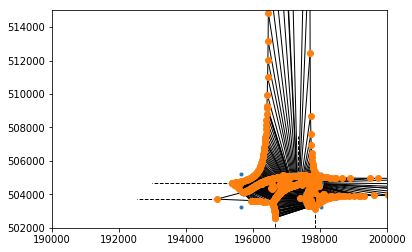

In [202]:
voronoi_plot_2d(vor)
plt.xlim(190000, 200000)
plt.ylim(502000, 515000)
plt.show()

In [ ]:
# Derive width and other parameters that are related to the river axis

# Convert of Python 2 to Python 3

In [10]:
from geojson import FeatureCollection
import json

In [13]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 08 13:47:12 2015

.. module:: network
    :platform: Windows
    :synopsis: Provides the medial_axis_transform_class
    
.. moduleauthor:: Dimitris Zervakis
.. supervisor::   Koen Berends <koen.berends@deltares.nl>

A river network is defined as a series of interconnected branches. Each branch
consists of a single polyline. This linear representation of the river network 
allows, even in heavily braided rivers, for a clear analysis of navigatability.



Dependencies:
    * numpy (1.7+)
    * matplotlib (for basic plotting only)
    * mat (should be available within the geometry package modules)
    * shapely (for writing to shapefiles)
    * shapefile (for reading shapefiles)
    

"""

import os
import numpy as np
import shapefile
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point
from scipy.spatial import Voronoi
from os.path import dirname, splitext
from shutil import copyfile
import common
from collections import OrderedDict
from datetime import datetime
from rtree import index


class Network:
    
    def __init__(self):
        self.library = {}
        
        self.SEpntDic = {} #Defined Start-End points for centrelines
        self.BRApntDic= {} #dictionary containing branching nodes (=points) per geometry
        self.pntsDic = {}  #point list per polygon
        self.bbpDic = {}   #bounding boxes of polygons
        self.pidDic = {}   #list of ids of points for parts of polygon: 
                           #'parts' are considered the outer rings and the holes
        self.polys = {}    #Polygons of the loaded geometries

        self.VorLS = {}    #LineStrings after Voronoi tesselation
        self.LSpnts = {}   #Point-Dictionary relating the LineStrings each key-point 'touches'
        
        self.branches = {}
        self.cnt = 0       #counter to attach names to the branches
        
        self.SEpoints = [] #temporary list of initial given Start-End points
        
        self.path = os.getcwd()+"\\"
        self.outputdir = os.path.join(os.getcwd())
        
    # ----------------------------------------------------------------
    # Public Methods
    # ----------------------------------------------------------------
    # These methods should be relatively easily accessable from outside         
    
    def load_geometries(self, polygons, se_points):
        
        #POLYGONS
        if type(polygons) is str:
            self.__read(polygons, "poly")
        else:
            try:
                cnt = -1
                for poly in polygons.data['data']:
                    cnt += 1
                    print("Polygon \"{0}\" deemed as #{1}.".format(poly, cnt))
                    self.pntsDic[cnt] = []
                    self.pidDic[cnt] = [0]
                    for part in range(len(polygons.data['data'][poly]['parts'])):
                        x = polygons.data['data'][poly]['parts'][part]['x']
                        y = polygons.data['data'][poly]['parts'][part]['y']
                        self.pntsDic[cnt].extend(list(zip(x,y)))
                        self.pidDic[cnt].append(len(self.pntsDic[cnt]))
                    x,y = list(zip(*self.pntsDic[cnt]))
                    self.bbpDic[cnt] = [min(x),min(y),max(x),max(y)]
            except AttributeError:
                print("ERROR: Failed to load Polygons!\n\n")
                return
            
        #Start-End (S-E) POINTS: These points define the closest branches which
        #will be kept after the skeleton of the polygon has been computed
        if type(se_points) is str:
            self.__read(se_points, "pnts")
        elif type(se_points) is list:
            self.SEpoints = se_points
        else:
            print("ERROR: Failed to load Start-End points!\n\n")
            return
        
        #Check that the chosen points are sufficient for finding the centerline:
        for gid in self.pntsDic.keys():
            self.SEpntDic[gid] = []
            self.BRApntDic[gid] = []
            pids = self.pidDic[gid]
            shell = self.pntsDic[gid][pids[0]:pids[1]]
            holes = [self.pntsDic[gid][pids[i]:pids[i+1]] for i in range(1,len(pids)-1)]
            self.polys[gid] = Polygon(shell,holes)
            for p in self.SEpoints:
                pnt = Point(p)
                if pnt.within(self.polys[gid]):
                    self.SEpntDic[gid].append(p)
        todel = []
        for gid in self.SEpntDic.keys():
            if len(self.SEpntDic[gid]) < 2:
                print("WARNING: The number of points for geometry #{0} is insufficient.".format(gid))
                print("         At least 2 points per geometry are required.")
                print("         Excluding computation of centerline for geometry #{0}.".format(gid))
                todel.append(gid)
        for d in todel:
            del self.SEpntDic[d]
            del self.BRApntDic[d]
            del self.pntsDic[d]
            del self.pidDic[d]
            del self.bbpDic[d]
            del self.polys[d]


    def densify(self, maxDistance):
        #maxDistance: the maximum allowed distance between 2 points of a polygon geometry
        #If the 2 consecutive points have a larger distance in between,
        #more points are added until their distance is within the threshold
    
        if maxDistance <= 0:
            print("\nWARNING: No desnsification for max distance=", maxDistance)
            return
        
        #---DENSIFY POLYGONS' GEOMETRIES:
        init = 0
        dens = 0
        for gid in self.pntsDic.keys(): #for each polygon
            numOfPnts = len(self.pntsDic[gid])-len(self.pidDic[gid])+1
            init += numOfPnts
            print("\nPolygon #{0}:\n\tInitial number of points: {1}".format(gid,numOfPnts))
            print("\t-> Densifying geometry...")
            dense_points = []
            dense_pid = [0]
            for p in range(len(self.pidDic[gid])-1): #for each part in polygon
                part = self.pntsDic[gid][ self.pidDic[gid][p]:self.pidDic[gid][p+1] ] #part of polygon (a shape: polygon or hole)
                for j in range(len(part)-1):
                    templs = LineString([part[j],part[j+1]]) #edge of polygon part (temporary)
                    #Find how many extra vertices should be placed in a linestring segment:
                    EXTRAVERT = 0
                    toolong = True
                    l = float(templs.length) #desired length
                    while toolong:
                        if l > maxDistance:
                            EXTRAVERT += 1
                            l = float(templs.length) / (EXTRAVERT+1)
                        else:
                            toolong = False
                    tempps = [] #points per segment, avoiding last point in segment
                    for e in range(EXTRAVERT+1):
                        tempps.append(list(templs.interpolate(e*l).coords[0]))
                    dense_points.extend(tempps)
                dense_points.append(part[-1]) #close part
                dense_pid.append(len(dense_points))
            self.pntsDic[gid] = dense_points
            self.pidDic[gid] = dense_pid
            dens += len(self.pntsDic[gid])-len(self.pidDic[gid])+1
            print("\tDensified number of points: ", len(self.pntsDic[gid])-len(self.pidDic[gid])+1)
            #Create polygon objects for use in "within" comparisons later:
            print("-> Creating densified polygon...", end=' ')
            polyg = self.pntsDic[gid][ self.pidDic[gid][0]:self.pidDic[gid][1] ]
            holes =[]
            for h in range(len(self.pidDic[gid])-2):
                holes.append( self.pntsDic[gid][ self.pidDic[gid][h+1]:self.pidDic[gid][h+2] ] )
            self.polys[gid] = Polygon(polyg,holes)
            print("OK!")
        print("### Total number of points at start:", init)
        print("### Total number of points after densification:", dens)
        
    
    #holistic function that runs other functions
    def construct(self, spacing=[], skeletonFile=False, branchFile=False, voronoiFile=False):
        
        self.__voronoi(opt="Qbb",voronoiFile=voronoiFile) #construct voronoi lines of voronoi polygons and keep only the ones inside them
        self.__snap() #snap S-E points to real starting points
        if skeletonFile:
            self.__save_skeleton(filename=str(skeletonFile)+".shp")
        self.__clean() #remove all artifacts and keep only start-end point lines
        self.__topology() #construct the branches with correct topology
        
        if not spacing:
            print("\nWARNING: Keeping original result of voronoi tesselated centrelines.")
        else:
            if len(spacing) < len(self.polys):
                print("\nWARNING: Not enough spacing numbers. Further polygons gain the last spacing number.")
                ext = len(self.polys)-len(spacing)
                spacing = spacing + ext*[spacing[-1]]
            
            s = -1
            for gid in sorted(self.polys.keys()):
                s += 1
                for branch in list(self.branches[gid].keys()):
                    bLS = LineString(self.branches[gid][branch])
                    spaces = int( np.ceil( bLS.length / float(spacing[s]) ) )
                    new_branch = []
                    for i in np.linspace(0.0,1.0,spaces):
                        new_branch.append(bLS.interpolate(i,True).coords[:][0])
                    self.branches[gid][branch] = new_branch                    

        if branchFile:
            self.__save_branches(filename=str(branchFile)+".shp")
            
        #FOR CONSISTENCY (with the rest of ratin):
        for gid in list(self.polys.keys()):
            for branch in list(self.branches[gid].keys()):
                x,y = list(zip(*self.branches[gid][branch]))
                self.library[branch] = {}
                self.library[branch]['data'] ={}
                self.library[branch]['endpoint'] ={}
                self.library[branch]['startpoint'] ={}
                self.library[branch]['data']['x'] = list(x)
                self.library[branch]['data']['y'] = list(y)
                self.library[branch]['endpoint']['x'] = list(x)[-1]
                self.library[branch]['endpoint']['y'] = list(y)[-1]
                self.library[branch]['startpoint']['x'] = list(x)[0]
                self.library[branch]['startpoint']['y'] = list(y)[0]
        #find widths:
        #widths = self.__get_widths(degree) #only with "experimental" below; also "degree" needs to be input
        widths = self.__get_widths()
        for gid in list(self.polys.keys()):
            for branch in list(self.branches[gid].keys()):
                self.library[branch]['data']['width'] = widths[gid][branch]
 

    def save(self,outputfile, fileformat= 'rnw' ):
        '''
        Save network to file. The default output format is .rnw, a 
        'landboundary format'. The branch's topology and endpoint
        registration is saved as a polyline. The endpoint information is used
        by the network to identify 'open' and 'closed' ends. Open ends can be
        further investigated by the build algorithm. 
        
        The .rnw can be also be read by `Delft3D-QUICKPLOT <https://publicwiki.deltares.nl/display/OET/OPeNDAP+access+with+Delft3D-Quickplot>`_.
        
        Alternatively, the network can be saved to Esri Shapefile. The output
        will be a feature with polylines. 
        
        .. note:: A network cannot be imported from shapefile. 
        
        Args:
            outputfile (str): name/path of outputfile
            
        Kwargs:
            fileformat (str): possible formats: 'rnw','shape','shp','shapefile'
        '''
        supported_extensions = {'rnw':'.rnw', 'shape':'.shp','shp':'.shp', 'shapefile':'.shp'}
        try:
            extension = supported_extensions[fileformat]
        except KeyError:
            print('Error: unsupported fileformat')
            return
        
        outputfile = outputfile
        outputfile = outputfile.replace('\\','/')
        outputfile = outputfile.replace('//','/')
        if not(extension == '.shp'):
            with open(outputfile+extension,'w') as f:
                f.write('* Network file. Generated by RAT-IN on '+datetime.now().strftime("%Y-%m-%d %H:%M:%S")+'\n')
                f.write('*column 1 = x\n')
                f.write('*column 2 = y\n')
                f.write('*column 3 = width [m]\n') 
    
                for branch in self.library:
                    data = self.library[branch]['data']
                    node = self.library[branch]['endpoint']
                    #columns = 3  #???unused
                    rows = len(data['x'])
                    
                    f.write(branch+'\n')
                    f.write(str(rows)+' 3\n')
                    for row in range(0,rows):
                        f.write('   '+str('%.17E'%data['x'][row])+
                                '   '+str('%.17E'%data['y'][row])+
                                '   '+str('%.17E'%data['width'][row])+'\n')

                    for candidate in node:
                        if candidate[0] == 'C':
                            f.write(branch+'.'+candidate+'\n')
                            f.write('1 4\n')
                            f.write(str(node['x'])+' '+str(node['y'])+' '+
                            str(node[candidate][0]) +' '+str(node[candidate][1])+'\n')
        else:
            #SHAPEFILE
            w = shapefile.Writer(shapeType=1)
            mid = max([len(self.library[branch]['data']['x']) for branch in self.library])
            w.field("ID","N",len(str(mid)),0)
            w.field("BRANCH","C",15,0)
            w.field("X","N",40,8)
            w.field("Y","N",40,8)
            w.field("WIDTH","N",40,8)
            pid = 0
            for branch in self.library:        
                data = self.library[branch]['data']
                for i in range(len(data['x'])):
                    w.point(x=data['x'][i], y = data['y'][i])
                    w.record(pid,str(branch),data['x'][i],data['y'][i],data['width'][i])
                    pid+=1
            w.save(outputfile+extension)
            
            
    #TODO: Requires refiniment
    def load(self,inputfile):
        ''' 
        Import network from .rnw file. 
        
        Args:
            inputfile (str): inputfile
        '''
        flag_name = False
        flag_size = False
        flag_endpoint = False
        linenumber = 0
        
        self.list_of_branches = []
        ##??? if one is loading an rnw, there is no names in the library...
        for branchname in self.library:
            self.list_of_branches.append(branchname)
            
        with open(inputfile,'r') as f:
            for line in f:
                linenumber += 1
                if line[0] == '*':
                    pass
                else:                    
                    words = line.split()
                    dim = len(words)
                    if dim == 1:
                        if words[0][-3:-1] == '.C':
                            flag_endpoint = True
                            branch = words[0].split('.')
                            branchname= branch[0]
                            for branchi in range(1,len(branch)-1):
                                branchname = branchname+'.'+branch[branchi]
                        else:
                            flag_endpoint = False
                            branch = words[0]
                            branchname = branch
                            
                        # Check if branchname already exists
                        while branchname in self.list_of_branches:
                            print(branchname+' already in library, branchname changed to '+branchname+'.dup')
                            branchname = branchname+'.dup'
                            
                        flag_name = True
                        flag_size = False
                        if not(flag_endpoint):
                            self.library[branchname] = {'data':{'x':[],'y':[],'width':[]},'endpoint':{}}

                    elif flag_name and not(flag_size):
                        if not(dim==2):
                            print('Error: size definition len()> 2 on line ' +str(linenumber))
                            return
                        else: 
                            flag_size = True
                            flag_name = False
                    elif flag_size and not(flag_endpoint):
                        if not(dim==3):
                            print('Error: columns > 3 on line '+str(linenumber))
                        else:
                            self.library[branchname]['data']['x'].append(float(words[0]))
                            self.library[branchname]['data']['y'].append(float(words[1]))
                            self.library[branchname]['data']['width'].append(float(words[2]))
                    elif flag_size and flag_endpoint:
                        if not(dim==4):
                            print('Error: columns not equal to 4 on line '+str(linenumber))
                        else:
                            self.library[branchname]['endpoint']['x'] = float(words[0])
                            self.library[branchname]['endpoint']['y'] = float(words[1])
                            self.library[branchname]['endpoint'][branch[-1]] = [float(words[2]),float(words[3])]
                                                    
        # Set branch status  #??? not sure if needed, since the new network is used. Left for legacy.
        for branch in self.library:
            branch_open = False
            for endpoint in self.library[branch]['endpoint']:
                if endpoint[0] == 'C':
                    if self.library[branch]['endpoint'][endpoint][1] == 2:
                        branch_open = True
            if branch_open:
                self.library[branch]['status'] = 'open'
            else:
                self.library[branch]['status'] = 'closed'
        #update
        self.list_of_branches = list(self.library.keys())
        if not self.get_branchnames():
            for b in self.list_of_branches:
                self.branches[0] = {}
                self.branches[0][b] = list(zip(self.library[b]['data']['x'],self.library[b]['data']['y']))
        else:
            print("Too many polygons to load branch on.") #TODO: fix
    
    """
    #TODO: Requires refiniment - simpler though
    def load(self, inputfile):
        '''
        Reads a network file (.rnw) and loads it onto a library.
        
        Args:
            inputfile (str): inputfile
        '''    
        #initialize
        linenumber = 0
        library = {}
        current_branchname = None
        
        #parse
        with open(inputfile,'r') as f:
            for line in f:
                linenumber += 1
                if line[0] == '*':
                    continue #filter out comments
                else:                    
                    words = line.split()
                    dim = len(words)
                    if dim == 1: #new branch
                        current_branchname = str(words[0]) 
                        self.library[current_branchname] = {'data': {'x':[],'y':[],'width':[]} , \
                                                            'startpoint': {'x': None,'y':None} , \
                                                            'endpoint': {'x': None,'y':None} }
                        continue
                    elif dim == 2: #line with branch info
                        continue #currently irrelevant
                    elif dim == 3: #x,y,width
                        self.library[current_branchname]['data']['x'].append(float(words[0]))
                        self.library[current_branchname]['data']['y'].append(float(words[1]))
                        self.library[current_branchname]['data']['width'].append(float(words[2]))
                    else:
                        print 'Error: unexpected column (size>3) on line ' +str(linenumber)
        f.close() #close file
                                                   
        #start-end points for each branch
        for branch in library:
            self.library[branch]['startpoint']['x'] = self.library[branch]['data']['x'][0]
            self.library[branch]['startpoint']['y'] = self.library[branch]['data']['y'][0]
            self.library[branch]['endpoint']['x'] = self.library[branch]['data']['x'][-1]
            self.library[branch]['endpoint']['y'] = self.library[branch]['data']['y'][-1]
    """
        

    #TODO: change into library ones
    def get_branchnames(self, geometry='all'):
        '''
        Print branchnames to screen.
        '''
        bnames = []
        if geometry == 'all':
            for g in self.branches:
                print("Polygon #{0}:".format(g))
                print("\t",list(self.branches[g].keys()))
                bnames.append(list(self.branches[g].keys()))
        else:
            print("Polygon #{0}:".format(geometry))
            print("\t",list(self.branches[geometry].keys()))
            bnames.append(list(self.branches[g].keys()))
        return bnames
        
        
    def rename(self, oldbranchname, newbranchname):
        '''
        Renames a branch. To see the current branchnames, use the plot tool
        or alternatively, access the library dictionary:
        
        >>> network.plot()
        >>> # Or view branches of a specific polygon
        >>> network.get_branchnames('all')
        >>> # Or view directly
        >>> network.library.keys()
        
        Args:
            oldbranchname (str): the old branch name
            newbranchname (str): the new branchname
        '''
        for name in list(self.library.keys()):
            if name == newbranchname:
                print("Branch with name {0} already exists! Cannot rename.".format(name))
                return 0
        self.library[newbranchname] = self.library.pop(oldbranchname)
        
        
    def reverse(self, branchname):
        '''
        Reverses the branch's direction.
        '''
        try:
            self.library[branchname]['data']['x'].reverse()
            self.library[branchname]['data']['y'].reverse()
            self.library[branchname]['data']['width'].reverse()
            self.library[branchname]['startpoint'], self.library[branchname]['endpoint'] = self.library[branchname]['endpoint'], self.library[branchname]['startpoint']
        except KeyError:
            print("Branch with name {0} does not exist.".format(branchname))
            return


    def merge(self, branches, newbranchname):
        '''
        Merge branches together.
        
        Args:
            branches (list): list of strings containing names of old branches to be merged in order.
            newbranchname (str): name of the newly merges branch
            
        .. warning:: The ordering of the 'branches' input list is not trivial. The user should supply the necessecary ordering of the branches. 
        
        '''

        #Check that newbranchname is not being used:
        if self.rename(branches[0],str(newbranchname)) == 0:
            print("Cannot merge branches. Branches {0} did not merge".format(branches))
            return
        self.rename(str(newbranchname),branches[0])

        newdict = {'data': {'x':[],'y':[],'width':[]}, 'startpoint':{}, 'endpoint':{}}

        #Check that all specified branch names exist and that they can merge with others:
        for i in range(len(branches)):
            b = branches[i]
            try:
                branchdata = self.library[b]
            except KeyError:
                try:
                    branchdata = self.library[str(b)]
                except KeyError:
                    print('Branch '+str(b)+ ' does not exist.')
            
            if not newdict['data']['x']:
                newdict = branchdata
                del(self.library[b])
            else:
                if newdict['endpoint'] == self.library[b]['startpoint']:
                    pass
                elif newdict['endpoint'] == self.library[b]['endpoint']:
                    self.reverse(b)
                else:
                    print("Cannot merge branches. Branches {0} did not merge".format(branches[i:]))
                    break
                newdict['data']['x'].extend(branchdata['data']['x'][1:])
                newdict['data']['y'].extend(branchdata['data']['y'][1:])
                newdict['data']['width'].extend(branchdata['data']['width'][1:])
                newdict['endpoint'] = self.library[b]['endpoint'].copy()
                del(self.library[b])
            
        self.library[str(newbranchname)] = newdict.copy()
        

    def get_chainage(self, branch=False):
        '''
        Returns chainage (of vertices on branch)
        
        '''
        
        if not(branch):
            pass
        else:
            assert type(branch) == str
            
            x = self.library[branch]['data']['x']
            y = self.library[branch]['data']['y']
            
            #length of vertices from the start of the centerline
            return common.get_chainage(x,y)
 

    def get_direction(self, branch=False, units ='radians', smoothdegree=0):
        x = self.library[branch]['data']['x']
        y = self.library[branch]['data']['y']
        direction = common.get_direction(x, y, smoothdegree=smoothdegree, units=units)
        return direction
           
            
    def get_curvature(self, branch=False, units='radians', smoothdegree=0):
        '''
        Returns curvature of the branches
        
        output: 
        '''
        
        # Curvature is defined as the derivative of the direction ('theta') and
        # the chainage ('s')
        
        if not(branch):
            pass
        else:
            assert type(branch) == str

            s = self.get_chainage(branch=branch)
            theta = self.get_direction(branch = branch, units = units, smoothdegree=smoothdegree)
            
            #starting extra values are set to averages to have same extend
            curvature = np.diff(theta)/np.diff(s)
            curvature  = np.append(np.average(curvature[:int(smoothdegree)+1]),curvature)
            #---or---???
            #curvature = np.array([0])  #first value is set to zero
            #curvature = np.append(curvature, np.diff(theta)/np.diff(s))
            
#            #TODO: delete, this is just another expression of curvature - similar though
             #      (see:http://en.wikipedia.org/wiki/Curvature#Local_expressions)
#            x = self.library[branch]['data']['x']
#            y = self.library[branch]['data']['y']
#            fx = np.append(np.array([0]), np.diff(x))
#            ffx = np.append(np.array([0]), np.diff(fx))
#            fy = np.append(np.array([0]), np.diff(y))
#            ffy = np.append(np.array([0]), np.diff(fy))
#            curvature = (fx*ffy - ffx*fy) / ((fx**2+fy**2)**1.5)
#            curvature = common.smooth(curvature,smoothdegree)
            
            return curvature


    ##?? This can be altogether deleted and have width hardcodedly smoothened -
    ##?? unless the use is better external
    ##?? Be careful of not double-smoothing width!
    def smooth(self, branch = 'None', param = 'None', degree=5):
        '''
        Smooth a parameter
        '''
        if (param == 'None') or (branch=='None'):
            return
        elif not(type(param)==type('string')):
            return
        elif param.lower() == 'width':
            self.library[branch]['data']['width'] = common.smooth(self.library[branch]['data']['width'],degree)
            

    def delete(self, branch = 'None', num_of_pnts = 0):
        '''
        Delete points at start or end of a branch.
        '''
        num_of_pnts = int(num_of_pnts)
        if (branch=='None') or (num_of_pnts<=0):
            return
        self.library[branch]['data']['x'] = self.library[branch]['data']['x'][num_of_pnts:-num_of_pnts]
        self.library[branch]['data']['y'] = self.library[branch]['data']['y'][num_of_pnts:-num_of_pnts]
        self.library[branch]['data']['width'] = self.library[branch]['data']['width'][num_of_pnts:-num_of_pnts]
        self.library[branch]['endpoint']['x'] = self.library[branch]['data']['x'][-1]
        self.library[branch]['endpoint']['y'] = self.library[branch]['data']['y'][-1]
        self.library[branch]['startpoint']['x'] = self.library[branch]['data']['x'][0]
        self.library[branch]['startpoint']['y'] = self.library[branch]['data']['y'][0]
            
            
    def plot(self, fignum=1, param='none', block=False):
        '''
        Plot the current network. 
        
        Args:
            fignum (int): matplotlib figure number. Default = 1

        '''
        
        #region Create Figure
        fig = plt.figure(fignum)
        ax = fig.add_subplot(111)
        #endregion

        # Colors
        branchcolor = [0.3, 0.3, 0.8]
        vertexcolor = [0.6, 0.6 ,0.6]
        
        s = np.linspace(0.0,1.0,len(self.library)+2)
        
        c = 0
        for branch in self.library:
            c += 1
            if len(self.library) > 1:
                branchcolor = plt.cm.jet(s[c])
                vertexcolor = plt.cm.jet(s[c]/1.25)
            # Branch
            ax.plot(self.library[branch]['data']['x'],
                    self.library[branch]['data']['y'],
                    color = vertexcolor,
                    marker = '.')
            ax.plot(self.library[branch]['data']['x'],
                    self.library[branch]['data']['y'],
                    color = branchcolor)
            ax.plot(self.library[branch]['data']['x'][-1],
                    self.library[branch]['data']['y'][-1],
                    color = [0.1, 0.6, 0.6],
                    marker = 's')
            ax.plot(self.library[branch]['data']['x'][0],
                    self.library[branch]['data']['y'][0],
                    color = 'y',
                    marker = 'o')
            # Labels
            mid = int(len(self.library[branch]['data']['x'])/2)
            ax.annotate(branch,
                        xy = (self.library[branch]['data']['x'][mid],
                              self.library[branch]['data']['y'][mid] ),
                        xytext = (50,50),
                        textcoords = 'offset points', 
                        ha = 'right', va = 'bottom',
                        bbox = dict(boxstyle = 'square,pad=0.5', 
                                    fc = branchcolor, alpha = 0.5),
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0.3'))
        
        if not(param=='none'):
            ##?? What is the purpose of the sidebar depiction?? Nothing else is shown...
            if type(param)==type('string'):
                if param.lower() == 'width':
                    cl = ax.scatter(self.library[branch]['data']['x'],
                                    self.library[branch]['data']['y'],
                                    c = self.library[branch]['data']['width'],
                                    cmap = plt.cm.coolwarm, marker ='+',
                                    s=150,linewidths=4)
                elif param.lower() == 'curvature':
                    x = self.library[branch]['data']['x']
                    y = self.library[branch]['data']['y']
                    sx = [0]
                    sx.extend(np.sqrt(np.diff(x)**2+np.diff(y)**2)) 
                    sx = np.cumsum(sx)
                    theta = self.get_direction(branch)  #no smoothing
                    ##theta = common.smooth(theta)        #??? why smooth the depiction here??

                    # Curvature is:  k = d(theta)/d(s)
                    k = [0]
                    k.extend(np.diff(theta)/np.diff(sx))
                    cl = ax.scatter(self.library[branch]['data']['x'],
                                    self.library[branch]['data']['y'],
                                    c = k, cmap = plt.cm.coolwarm, marker ='+',
                                    s=150,linewidths=4)
                plt.colorbar(cl)
                
        plt.axis('equal')
        if block:
            plt.ioff()
        else:
            plt.ion()
        fig.show()
        
        
    def overview(self, branch, fignum=3, smoothdegree=5, printoutput=False, units='radians'):
        '''
        Displays a windows with three subplots of width, direction and 
        radius of curvature along the specified branch.
        
        If printoutput = True, output is printed to *current_directory*/demo_output
        
            
        '''
        
        # Plot settings        
        #fontProperties = {'family':'sans-serif','sans-serif':['Arial'],
        #                  'weight' : 'normal', 'size' : 8}  ##?? unused?
    
        # Create figure and axes
        fig = plt.figure(fignum)
        plt.clf()
        axWidth = fig.add_subplot(311)
        axTheta = fig.add_subplot(312)
        axCurv = axTheta.twinx()
        axR     = fig.add_subplot(313)
        
        # Retrieve x,y data
        x = self.library[branch]['data']['x']
        y = self.library[branch]['data']['y']
        
        # Calculate chainage, direction and curvature. Also retrieve width.
        s = self.get_chainage(branch) * 0.001 #*0.3048  #along river, in km
        theta = self.get_direction(branch, units = units, smoothdegree=0.0)
        k = self.get_curvature(branch, units = units, smoothdegree=0.0)
        width = np.array(self.library[branch]['data']['width']) #* 0.3048


        #TODO: REVIEW:
        # User-specified transformations 
        smoothTheta = self.get_direction(branch, units = units, smoothdegree=smoothdegree)   
        #smoothK = self.get_curvature(branch, units=units, smoothdegree=smoothdegree)
        #smoothTheta = common.smooth(theta,degree=smoothdegree)
        #smoothK = k*width/np.average(width)
        smoothK = common.smooth(k,degree=smoothdegree)
        smoothWidth = common.smooth(width,degree=smoothdegree)
        
        # The radius of curvature is the inverse of the curvature. Curvature 
        # can be 0 though, which leads to zero division. 
        k_for_radius = self.get_curvature(branch, units='radians', smoothdegree=0.0)
        k_for_radius[k_for_radius==0] = 1e-20
        R = np.abs(1./np.array(k_for_radius))
        smoothR = common.smooth(R,degree=smoothdegree)

        
        #------------------- WIDTH
        axWidth.plot(s,width,color=[0.6,0.6,0.6])
        axWidth.plot(s,smoothWidth,color='k')
        axWidth.tick_params(axis='both',which='major',labelsize=10,color=[0.3,0.3,0.3])
        axWidth.tick_params(axis='both',which='minor',labelsize=8)
        axWidth.minorticks_on()
        axWidth.set_ylabel('Width [m]',fontdict={'fontsize':10},color='k') #[1.0,0.7,0.2]
        axWidth.set_title(branch,fontdict={'fontsize':12})
        axWidth.grid(b=True,which='both',axis='both',color=[0.3,0.3,0.3])
        
        #------------------- THETA
        axTheta.plot(s,theta,color=[0.6,0.6,0.6])
        axTheta.plot(s,smoothTheta,color=[0,0.7,0.2])
        axTheta.tick_params(axis='both',which='major',labelsize=10,color=[0.3,0.3,0.3])
        axTheta.tick_params(axis='both',which='minor',labelsize=8)
        axTheta.minorticks_on()
        axTheta.set_ylabel('Direction ['+units+']',fontdict={'fontsize':10},color=[0,0.7,0.2])
        axTheta.grid(b=True,which='both',axis='both',color=[0.3,0.3,0.3])
        
        #------------------- CURVATURE
        axCurv.plot(s,k,color=[0.6,0.6,0.6])
        axCurv.plot(s,smoothK,color=[0.2,0.0,1.0])
        axCurv.set_ylabel('Curvature ['+units+'/m]',fontdict={'fontsize':10},color=[0.2,0.0,1.0])
        
        #------------------- RADIUS OF CURVATURE
        axR.plot(s,R,color=[0.6,0.6,0.6])
        axR.plot(s,smoothR,color=[1,0.3,0.3])
        axR.set_ylim([10,1e7])
        axR.set_yscale('log')
        axR.set_ylabel('Radius of Curvature [m]',fontdict={'fontsize':10},color=[1,0.3,0.3])
        axR.grid(b=True,which='major')
        
        
        plt.ion()
        plt.show()
        
        if printoutput:
            csvdict = OrderedDict()
            csvdict['x'] = x
            csvdict['y'] = y
            csvdict['width'] = width
            csvdict['curvature'] = smoothK
            csvdict['radiusofcurvature'] = smoothR
            self.__overview2csv(csvdict)


    # ----------------------------------------------------------------
    # Static Methods
    # ----------------------------------------------------------------
    
    @staticmethod
    def _build_rtree(ls):
        '''
        R-tree implementation for linestrings.
        '''
        idx = index.Index()
        for i in range(len(ls)):
            idx.insert(i, LineString(ls[i]).bounds)
        return idx

        
    # ----------------------------------------------------------------
    # Private Methods
    # ----------------------------------------------------------------
    # These methods are for internal use only       

    def __read(self, filename, which = "poly"):

        FILE = filename
        FILE = FILE.replace('\\','/')
        FILE = FILE.replace('//','/')
        self.path = FILE
        
        extension = os.path.splitext(filename)[-1]
        
        if extension == ".shp":
            #---READ FILE:
            sf = shapefile.Reader(FILE)
            if which == "poly":
                print("\n-> Reading file: {0}".format(FILE))
                print("Reading: {0} number of records".format(sf.numRecords))
                for i in range(sf.numRecords):
                    rectype = sf.shapes()[i].__geo_interface__["type"]
                    if rectype != "Polygon":
                        print("Warning: Geometry excluded (type: {0})".format(rectype))
                        continue
                    else:
                        print(rectype,"#{0}:".format(i), end=' ')
                    self.pntsDic[i] = sf.shapes()[i].points
                    self.pidDic[i] = list(sf.shapes()[i].parts) + [len(self.pntsDic[i])]
                    x,y = list(zip(*self.pntsDic[i]))
                    self.bbpDic[i] = [min(x),min(y),max(x),max(y)]
                    #self.bbpDic[i] = sf.bbox
                    print("OK!")
                print("End of reading.")
            elif which == "pnts":
                if (sf.numRecords < 2) or (sf.shapeType != 1):
                    raise Exception('Input POINT file must be of at least 2 start/end points!')
                #Start and end points: At least 2 points per geometry need to be given as input
                # in order to compute the centerline
                self.SEpoints = [sf.shapes()[i].points[0] for i in range(len(sf.shapes()))]
            #Close file:
            sf.shp.close()
            sf.dbf.close()
            sf.shx.close()
        elif extension in [".ldb",".xyz"]:  ##??may require refinement - especially for polygons with holes etc...
            inputformat = {'comment': ['"','!','#','@','$','%','*','<','^','&'],
                           'nanvalues':[-999,999,99999,999999,999.999]}
            if which == "poly":
                cnt = 0
                with open(filename, 'r') as F:
                    print("Polygon#{0}:".format(cnt), end=' ')
                    self.pntsDic[cnt] = []
                    for i, line in enumerate(F):
                        if (extension == ".ldb") and (i < 5):
                            continue
                        words = line.split()
                        if (not words) or (words[0][0] in inputformat['comment']):
                            continue #skip empty lines and lines with comments
                        if (words[0][0] in inputformat['nanvalues']):
                            cnt += 1
                            print("Polygon#{0}:".format(cnt), end=' ')
                            self.pntsDic[cnt] = []
                            continue
                        self.pntsDic[cnt].append(tuple(float(words[0]),float(words[1])))
                for i in range(cnt+1):
                    self.pidDic[i] = [0, len(self.pntsDic[i])]
                    x,y = list(zip(*self.pntsDic[i]))
                    self.bbpDic[i] = [min(x),min(y),max(x),max(y)]
            elif which == "pnts":
                with open(filename, 'r') as F:
                    for i, line in enumerate(F):
                        if (extension == ".ldb") and (i < 5):
                            continue
                        words = line.split()
                        if (not words) or (words[0][0] in inputformat['comment']):
                            continue #skip empty lines and lines with comments
                        if (words[0][0] in inputformat['nanvalues']):
                            continue
                        self.SEpoints.append([float(words[0]),float(words[1])])
        elif extension in ['.geojson', 'json']:
            if which == "poly":
                print("\n-> Reading file: {0}".format(FILE))
                with open(FILE) as fin:
                    data = json.load(fin)

                if data['type'] == 'Feature':
                    data = FeatureCollection([data])

                for iFeature in range(len(data['features'])):
                    self.pntsDic[iFeature] = []
                    self.pidDic[iFeature] = [0]
                    for polygon in data['features'][iFeature]['geometry']['coordinates']:
                        self.pntsDic[iFeature].extend(polygon)
                        self.pidDic[iFeature].append(self.pidDic[iFeature][-1] + len(polygon))
                        x,y = zip(*self.pntsDic[iFeature])
                        self.bbpDic[iFeature] = [min(x),min(y),max(x),max(y)]
            else:
                 print('Type not implemented')
        else:
            print("Error: Load not implemented for extension type:", extension)
            return

    #ORIGINAL idea: (and quite fast)
    #Calculates widths from the centerline point to the polygon's closest linestring
    def __get_widths(self):
        print("\n-> Calculating widths...")
        w = {}
        for gid in list(self.polys.keys()):
            w[gid] = {}

            ls = []
            #exterior
            lines = self.polys[gid].exterior.coords[:]            
            for i in range(len(lines)-1):
                ls.append([lines[i],lines[i+1]])
            #interior
            for j in range(len(self.polys[gid].interiors)):
                lines = self.polys[gid].interiors[j].coords[:]
                for i in range(len(lines)-1):
                    ls.append([lines[i],lines[i+1]])

            #R-tree data structure, for faster "nearest" queries
            ls_index = self._build_rtree(ls)
            ls = np.array(ls) #change type, so that ls can be easily indexed

            #for each branch of river polygon
            for branch in list(self.branches[gid].keys()):
                print("Branch #",branch)
                w[gid][branch] = []
                #for each point of the branch (=centerline)
                for p in (self.branches[gid][branch]):
                    minwidth = []
                    #check point's distance to line segment
                    #choose 10 closest line segments to be certain of correctness
                    ls_nearest = list(ls_index.nearest(p,10))
                    for l in ls[ls_nearest]:
                        x0,y0 = p
                        x1,y1 = l[0]
                        x2,y2 = l[1]
                        vx, vy = x1-x0, y1-y0
                        ux, uy = x2-x1, y2-y1
                        length = ux**2 + uy**2
                        det = -vx*ux + -vy*uy
                        if det<0:
                            dsq = vx**2 + vy**2
                        elif det>length:
                            dsq = (x2-x0)**2 + (y2-y0)**2
                        else:
                            det = ux*vy - uy*vx
                            dsq = det**2 / length
                        minwidth.append(dsq)
                    minwidth.sort()
                    w[gid][branch].append( np.sqrt(minwidth[0]) * 2 )
                    
        print("Finished.\n")
        return w
        
        
        
        
#    #USING SHAPELY (slower)
#    def __get_widths(self):
#        print "\n-> Calculating widths..."
#        w = {}
#        for gid in self.polys.keys():
#            w[gid] = {}
#
#            ls = [LineString(self.polys[gid].exterior.coords[:])]
#            for i in range(len(self.polys[gid].interiors)):
#                ls.append(LineString(self.polys[gid].interiors[i].coords[:]))
#            
#            for branch in self.branches[gid].keys():
#                w[gid][branch] = []
#                for i in range(len(self.branches[gid][branch])):
#                    P = Point(self.branches[gid][branch][i])
#
#                    mindist = float('inf')
#                    minwidth = float('inf')
#                    for l in ls:
#                        if P.distance(l) < mindist:
#                            mindist = P.distance(l)
#                            minwidth = mindist*2.0
#                    
#                    w[gid][branch].append(minwidth)
#        print "Finished.\n"
#        return w
    
#    #experimental: (works! BUT! needs a radius to be efficient)
#    def __get_widths(self,degree):
#        print "\n-> Calculating widths..."
#        w = {}
#        for gid in self.polys.keys():
#            w[gid] = {}
#
#            ls = [LineString(self.polys[gid].exterior.coords[:])]
#            for i in range(len(self.polys[gid].interiors)):
#                ls.append(LineString(self.polys[gid].interiors[i].coords[:]))
#            
#            for branch in self.branches[gid].keys():
#                w[gid][branch] = []
#                directions = self.get_direction(branch,'radians',smoothdegree=degree)
#                
#                for i in range(len(self.branches[gid][branch])):
#                    d1 = directions[i] + np.pi/2.0
#                    d2 = directions[i] - np.pi/2.0
#                    #TODO: FIX! How to find the FIRST point that intersects with the verticals?
#                    r = 5000.0 #?????random radius search
#                    
#                    x0,y0 = self.branches[gid][branch][i]
#                    x1,y1 = x0+r*np.cos(d1), y0+r*np.sin(d1)
#                    x2,y2 = x0+r*np.cos(d2), y0+r*np.sin(d2)
#                    
#                    ls1 = LineString([[x0,y0],[x1,y1]])
#                    ls2 = LineString([[x0,y0],[x2,y2]])
#                    p0 = Point(self.branches[gid][branch][i])
#                    
#                    
#                    mindist = float('inf')
#                    minwidth = float('inf')
#                    for l in ls:
#                        inter1 = ls1.intersection(l)
#                        inter2 = ls2.intersection(l)
#                        if inter1.type == 'Point':
#                            l1 = inter1.distance(p0)
#                        else:
#                            l1 = inter1[0].distance(p0)
#                        if inter2.type == 'Point':
#                            l2 = inter2.distance(p0)
#                        else:
#                            l2 = inter2[0].distance(p0)
#                        min1_2 = min([l1,l2])
#                        if min1_2 < mindist:
#                            mindist = min1_2
#                            minwidth = mindist*2.0
#                    
#                    w[gid][branch].append(minwidth)
#        print "Finished.\n"
#        return w
        
        
###############################################################################
        
#TODO: Make a general save function
    def __save_skeleton(self, filename="skeleton.shp"):
        print("\nWriting to file...")
        w = shapefile.Writer(shapefile.POLYLINE)
        w.field('ID','N',len(str(list(self.VorLS.keys())[0])),0)
        for gid in list(self.VorLS.keys()):
            templscoords = []
            for ls in self.VorLS[gid]:
                templscoords.append(ls.coords[:])
            w.line(parts = templscoords)
            w.record(int(gid))
        output = dirname(self.path)+"\\"+filename
        w.save(output)
        try:
            copyfile(splitext(self.path)[0]+".prj",dirname(self.path)+"\\"+filename+".prj")
        except:
            print("Warning: Skeleton Projection File could not be created.")
        print("SUCCESS! :)")
        print("Shapefile written in:", output)
        #Close file:
        w.shp.close()
        w.dbf.close()
        w.shx.close()
 
#TODO: Make a general save function
    def __save_branches(self, filename="branches.shp"):
        print("\nWriting BRANCHES to file...")
        w = shapefile.Writer(shapefile.POLYLINE)
        w.field('ID','N',len(str(self.cnt)),0)
        for gid in list(self.branches.keys()):
            for br in list(self.branches[gid].keys()):
                w.line(parts = [self.branches[gid][br]])
                w.record(int(br))
        output = dirname(self.path)+"\\"+filename
        w.save(output)
        try:
            copyfile(splitext(self.path)[0]+".prj",dirname(self.path)+"\\"+filename+".prj")
        except:
            print("Warning: Branches Projection File could not be created.")
        print("SUCCESS! :)")
        print("Branches shapefile written in:", output)
        #Close file:
        w.shp.close()
        w.dbf.close()
        w.shx.close()
        
        
    #TODO: delete OR make a normal function for saving voronoi graph    
    def __lalasave(self, polygons, filename="voronoia.shp"):
        print("\nWriting VORONOI to file...")
        w = shapefile.Writer(shapefile.POLYGON)
        w.field('ID','N',len(str(len(polygons))),0)
        c = 0
        for p in polygons:
            tempp = []
            for cc in p:
                tempp.append(list(cc))
            tempp.append(list(p[0]))
            w.poly(parts=[tempp])
            w.record(c)
            c+=1
        output = dirname(self.path)+"\\"+filename+'.shp'
        w.save(output)
        print("SUCCESS! :)")
        print("Voronoi shapefile written in:", output)
        #Close file:
        w.shp.close()
        w.dbf.close()
        w.shx.close()        
        
        
###############################################################################


    def __voronoi(self, opt="Qbb", voronoiFile=False):
        #--VORONOI TESSELATION
        print("\n-> Defining Voronoi polygons...")
        for gid in self.pntsDic.keys():
            print("\nPolygon #{0}:".format(gid))
            self.VorLS[gid] = []
            self.LSpnts[gid] = {} #dictionary with keys the points of linestrings inside the
                                  #polygon and values the ids of linestrings they 'touch'
            #include bounding points to 'close' polygons for voronoi
            bbpoints = [ [self.bbpDic[gid][0],self.bbpDic[gid][1]],   #SW
                         [self.bbpDic[gid][2],self.bbpDic[gid][3]],   #NE
                         [self.bbpDic[gid][0],self.bbpDic[gid][3]],   #NW
                         [self.bbpDic[gid][2],self.bbpDic[gid][1]] ]  #SE
            #Voronoi:
            vor = Voronoi(self.pntsDic[gid]+bbpoints,qhull_options=opt) #create voronoi polygons
            vor.close()
            
            #TODO: Delete!
            if voronoiFile:
                vorpolys = []
                for i in range(len(vor.regions)):
                    if vor.regions[i]:
                        vorpolys.append(list(vor.vertices[vor.regions[i]]))
                self.__lalasave(vorpolys,str(voronoiFile))
            
            
            for c,ridge in enumerate(vor.ridge_vertices):
                if c%1000==0:
                    print("\t{0} out of {1} segments processed".format(c,len(vor.ridge_vertices)))
                if -1 not in ridge:
                    tempLS = LineString( [tuple(vor.vertices[ridge[0]]),tuple(vor.vertices[ridge[1]])] )
                    
                    if self.polys[gid].contains(tempLS): #keep only lines inside the polygons
                        self.VorLS[gid].append(tempLS)
                        pntS = tempLS.coords[0]   #starting point
                        pntE = tempLS.coords[1]   #ending point
                        lsnum = len(self.VorLS[gid])-1 #linestring id
                        #add to skeleton dictionary of points:
                        if pntS in self.LSpnts[gid]:
                            self.LSpnts[gid][pntS].append(lsnum)
                        else:
                            self.LSpnts[gid][pntS] = [lsnum]
                        if pntE in self.LSpnts[gid]:
                            self.LSpnts[gid][pntE].append(lsnum)
                        else:
                            self.LSpnts[gid][pntE] = [lsnum]
            print("\tAll segments processed.")
            
    
    def __snap(self):
        #Snap input points to real 'lonely' points on assumed skeleton:
        print("\n-> Snapping significant points to skeleton...")
        for gid in self.SEpntDic.keys():  #for each polygon that has S-E points
            for i in range(len(self.SEpntDic[gid])): #for each S-E point
                mindist = float("inf")
                SEP = Point(self.SEpntDic[gid][i])
                for pnt in self.LSpnts[gid].keys(): #check all points in related polygon skeleton
                    if len(self.LSpnts[gid][pnt]) < 2:
                        lp = Point(pnt)
                        if SEP.distance(lp) < mindist:
                            mindist = SEP.distance(lp)
                            self.SEpntDic[gid][i] = pnt


    def __clean(self):
        print("\n-> Cleaning...")
        for gid in self.LSpnts.keys():
            print("Polygon #{0}".format(gid))
            deletedLS = []
            flag = True #indicates that there might still be 'lonely' linestrings leftover to clean
            while flag:
                flag = False
                for pnt in self.LSpnts[gid].keys():
                    #find 'lonely' points (points touching only 1 linestring):
                    if len(self.LSpnts[gid][pnt]) == 1:

                        lsID = self.LSpnts[gid][pnt][0]  #id of 'lonely' linestring
                        pntS = self.VorLS[gid][lsID].coords[0] #start-point of linestring
                        pntE = self.VorLS[gid][lsID].coords[1] #end-point of linestring
                    
                        #avoid deleting lines leading to significant points
                        if (pntS in self.SEpntDic[gid]) or (pntE in self.SEpntDic[gid]):
                            continue
                        flag = True
                        deletedLS.append(self.LSpnts[gid][pnt].pop()) #delete 'lonely' linestring
                        #find connecting point on linestring and delete the linestring id:
                        if pntS == pnt:
                            nextpnt = pntE
                        else:
                            nextpnt = pntS
                        if deletedLS[-1] in self.LSpnts[gid][nextpnt]:
                            self.LSpnts[gid][nextpnt].pop(self.LSpnts[gid][nextpnt].index(deletedLS[-1])) #update
            #Update linestrings
            setDel = set(deletedLS)
            setFull = set(range(len(self.VorLS[gid])))
            setIncl = setFull.difference(setDel)
            self.VorLS[gid] = [self.VorLS[gid][i] for i in setIncl]
            
        print("Finished cleaning.")
        
        
    def __topology(self):
        
        #Reconstruct remaining linestrings
        print("\n-> Constructing topology...")
        LSpnts = {}
        BRApowDic = {} #dictionary containing the number of converging lines
        for gid in self.VorLS.keys():
            LSpnts[gid] = {}
            BRApowDic[gid] = []
            lsnum = -1
            for ls in self.VorLS[gid]:
                pntS = ls.coords[0]   #starting point
                pntE = ls.coords[1]   #ending point
                lsnum += 1 #linestring id
                #add to dictionary of points:
                if pntS in LSpnts[gid]:
                    LSpnts[gid][pntS].append(lsnum)
                else:
                    LSpnts[gid][pntS] = [lsnum]
                if pntE in LSpnts[gid]:
                    LSpnts[gid][pntE].append(lsnum)
                else:
                    LSpnts[gid][pntE] = [lsnum]
            for pnt in LSpnts[gid].keys(): #collect branching points
                if len(LSpnts[gid][pnt]) > 2:
                    self.BRApntDic[gid].append(pnt)
                    BRApowDic[gid].append(len(LSpnts[gid][pnt]))
                
        #Construct the branches, starting from the Start-End points.
        #The direction of flow can be dictated by the user afterwards.
        for gid in self.SEpntDic.keys():
            self.branches[gid] = {} #a centreline consists of branches
            LStravelled = []   #list to keep track of travelled linestrings
            SEpntReached = []  #list for avoiding travelling the line back on the other direction
            endList = self.SEpntDic[gid] + self.BRApntDic[gid]
            
            
            #STARTING POINTS:
            for Spnt in self.SEpntDic[gid]:  #make a start for each start-end point

                if Spnt in SEpntReached:
                    continue #avoid end-points (single-centrelines)
                
                self.cnt += 1
                self.branches[gid][str(self.cnt)] = [Spnt]  #initialization
                nextpoint = None
                
                while nextpoint not in endList:
                    currpoint = self.branches[gid][str(self.cnt)][-1]
                    LScands = set(LSpnts[gid][currpoint]) #linestrings current point is connected to
                    LStrvld = set(LStravelled)
                    ls = list(LScands.difference(LStrvld))
                    if not ls:
                        break #if no new possible linestring available, stop
                    LStravelled.append(ls[0])
                    ls = self.VorLS[gid][ls[0]].coords[:]
                    if ls[0] == currpoint:
                        nextpoint = ls[1]
                    elif ls[1] == currpoint:
                        nextpoint = ls[0]
                    else:
                        print("****WEIRD!!!!***")
                    self.branches[gid][str(self.cnt)].append(nextpoint)
                
                if nextpoint in self.SEpntDic[gid]:
                    SEpntReached.append(nextpoint)
                elif nextpoint in self.BRApntDic[gid]:
                    indx = self.BRApntDic[gid].index(nextpoint)
                    BRApowDic[gid][indx] -= 1
                    
            #BRANCHING POINTS:
            while sum(BRApowDic[gid]) != 0:
                for Bpnt in self.BRApntDic[gid]:  #make a start for each branching point
                    
                    indx = self.BRApntDic[gid].index(Bpnt)
                    if BRApowDic[gid][indx] == 0:
                        continue
                    BRApowDic[gid][indx] -= 1
                    
                    self.cnt += 1
                    self.branches[gid][str(self.cnt)] = [Bpnt]  #initialization
                    nextpoint = None
                    
                    while nextpoint not in self.BRApntDic[gid]:
                        currpoint = self.branches[gid][str(self.cnt)][-1]
                        LScands = set(LSpnts[gid][currpoint]) #linestrings current point is connected to
                        LStrvld = set(LStravelled)
                        ls = list(LScands.difference(LStrvld))
                        LStravelled.append(ls[0])
                        ls = self.VorLS[gid][ls[0]].coords[:]
                        if ls[0] == currpoint:
                            nextpoint = ls[1]
                        elif ls[1] == currpoint:
                            nextpoint = ls[0]
                        self.branches[gid][str(self.cnt)].append(nextpoint)
                    
                    indx = self.BRApntDic[gid].index(nextpoint)
                    BRApowDic[gid][indx] -= 1
                    
        print("Topologies have been successfully created.")
        
        
    def __overview2csv(self,csvdict,outputfile=r'network_overview.csv'):
        
        outfile = self.outputdir+outputfile
        with open(outfile,'w') as f:
            # Write header
            for key in csvdict:
                f.write(key+',')
#             f.seek(-1, os.SEEK_END)
#             f.truncate() #delete last ","
            f.write('\n')
            lastkey = key
            
            # Write body
            for row in range(0,len(csvdict[lastkey])):
                for key in csvdict:
                    f.write(str(csvdict[key][row])+',')
                f.write('\n')
                
            print('output written to '+outfile)
            


-> Reading file: output/ijssel_N_polygon.geojson

Polygon #0:
	Initial number of points: 466
	-> Densifying geometry...
	Densified number of points:  2066
-> Creating densified polygon... OK!
### Total number of points at start: 466
### Total number of points after densification: 2066

-> Defining Voronoi polygons...

Polygon #0:
	0 out of 6194 segments processed
	1000 out of 6194 segments processed
	2000 out of 6194 segments processed
	3000 out of 6194 segments processed
	4000 out of 6194 segments processed
	5000 out of 6194 segments processed
	6000 out of 6194 segments processed
	All segments processed.

-> Snapping significant points to skeleton...

-> Cleaning...
Polygon #0
Finished cleaning.

-> Constructing topology...
Topologies have been successfully created.

-> Calculating widths...
Branch # 1
Finished.



D:\software\Anaconda3\envs\main\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


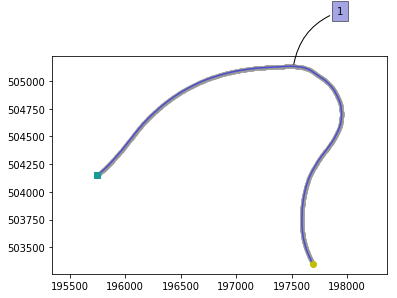

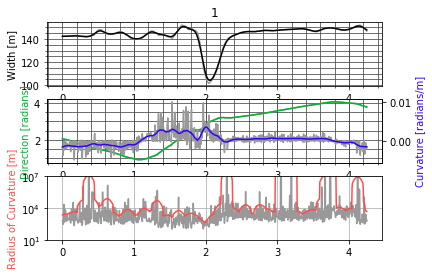

output written to D:\projecten\RATIN\RAT-IN\eo-river\notebooksnetwork_overview.csv


In [14]:
STARTEND = [ [197727.048,503291.164], [195687.574,504118.171] ]
SMOOTHDEGREE, cutpoints, densi, space, horiLines = 15.0, 20, 5.0, 5.0, 15  #dense grid

network = Network()
network.load_geometries(geojsonfile, se_points=STARTEND)
network.densify(densi)
network.construct(spacing=[space])
network.delete(branch='1', num_of_pnts=cutpoints)
#Representation
network.plot(1)
#Network Stats:
network.overview(branch='1', fignum=2, smoothdegree=SMOOTHDEGREE, printoutput=True, units='radians')
#Save output of network file
network.save('output/network')
